# Scratch Notebook

In [204]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
config.update("jax_debug_nans", True)
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import optax
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
from distributions import Gaussian as G

# check if dists have correct statistics

In [186]:
%autoreload

In [185]:
def check_dist(dist, key):
    s = dist.sample(10**4, key=key)
    errs = {
        "se_mean": np.sum((np.mean(s, axis=0) - dist.mean)**2),
        "se_cov": np.sum((np.cov(s, rowvar=False) - dist.cov)**2),
    }
    for k, err in errs.items():
        if err > 1e-2:
            print(f"{k} to big! {k} = {err} > 0.01")
    return

In [175]:
dist = distributions.Gaussian(0, 1)
check_dist(dist, key)

In [176]:
dist, _ = distributions.funnel.get()
check_dist(dist, key) # fine, just hard to approximate

se_mean to big! se_mean = 0.024607248604297638 > 0.01
se_cov to big! se_cov = 299.673095703125 > 0.01


In [177]:
dist, _ = distributions.banana_target.get()
check_dist(dist, key) # fine

se_cov to big! se_cov = 1.4945508241653442 > 0.01


In [178]:
dist, _ = distributions.ring_target.get()
check_dist(dist, key) # fine

se_cov to big! se_cov = 1.3806085586547852 > 0.01


In [187]:
dist, _ = distributions.squiggle_target.get()
check_dist(dist, key) # fine

se_cov to big! se_cov = 0.2666354775428772 > 0.01


In [202]:
s = dist.sample(1000000)
np.cov(s, rowvar=False)

DeviceArray([[0.99962336, 0.0016163 ],
             [0.0016163 , 1.1004082 ]], dtype=float32)

In [189]:
dist.cov

DeviceArray([[1.        , 0.        ],
             [0.        , 0.60002273]], dtype=float32)

In [ ]:
s = G(0, 1)

# Tensoflow probability

In [9]:
import seaborn as sns

In [10]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [11]:
dist = tfd.Normal(0., 1.)
print(dist.log_prob(0.))

-0.9189385


In [13]:
weights = np.array([1, 1, 4], dtype=np.float32)
means = np.array([[10, 10],
               [-10, 10],
               [0, 0]], dtype=np.float32)
covs = np.array([[1, 1],
                  [2, 2],
                  [3, 3]], dtype=np.float32)
gauss_mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=weights),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=means,
        scale_diag=covs)
)

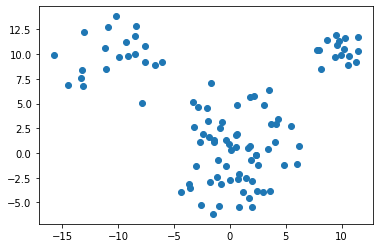

In [14]:
s = gauss_mix.sample(seed=key, sample_shape=(100,))
plot.scatter(s)

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


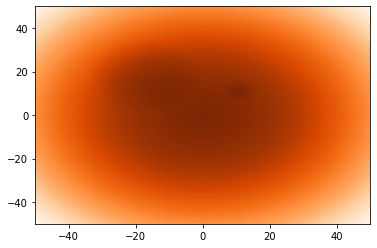

In [15]:
plot.plot_fun_2d(gauss_mix.log_prob, lims=(-50, 50))

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


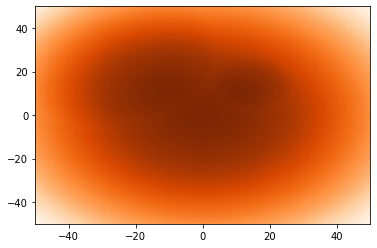

In [19]:
# compare
gm = distributions.GaussianMixture(means, [1, 2, 3], weights)
plot.plot_fun_2d(gm.logpdf, lims=(-50, 50))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


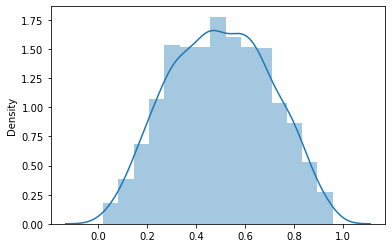

In [17]:
dist = tfd.TransformedDistribution(
    tfd.Normal(0., 1.),
    tfb.Sigmoid()
)
sns.distplot(dist.sample(1000, seed=random.PRNGKey(0)))
plt.show()

# New targets

In [84]:
%autoreload

(-3.0, 3.0)

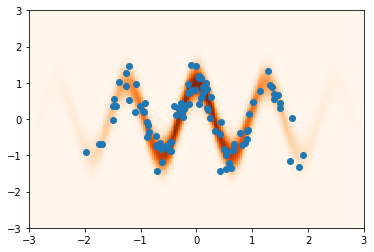

In [99]:
squiggle = distributions.Squiggle([0, 0], [1, .1])
s = squiggle.sample(100)

plot.plot_fun_2d(squiggle.pdf, lims=(-5, 5), num_gridpoints=300)
plot.scatter(s)
plt.ylim((-3, 3))
plt.xlim((-3, 3))

In [51]:
# Mixture of Gaussians
means = np.array([np.exp(2j*np.pi*x) for x in np.linspace(0, 1, 6)[:-1]])

[(-2.0, 2.0), (-2.0, 2.0)]

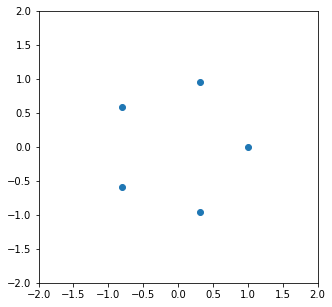

In [52]:
fig, ax = plt.subplots(figsize=[5,5])
ax.scatter(means.real, means.imag)
lim = (-2, 2)
ax.set(ylim=lim, xlim=lim)

In [53]:
means = np.column_stack((means.real,means.imag))

In [106]:
means.shape

(5, 2)

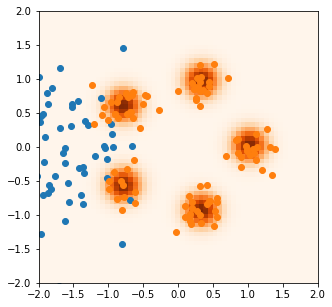

In [127]:
mix = distributions.GaussianMixture(means, .03, np.ones(5))
fig, ax = plt.subplots(figsize=[5,5])
s = mix.sample(100)
plot.plot_fun_2d(mix.pdf)
lim=(-2, 2)
ax.set(ylim=lim, xlim=lim)
plot.scatter(distributions.Gaussian([-2, 0], [.5,.5]).sample(100))
plot.scatter(s)

# Study MLP gradient field at initialization

In [69]:
dim = 2
net = nets.build_mlp(sizes=[32, 32, dim])
x_dummy = np.ones(dim)
key, subkey = random.split(key)
params = net.init(subkey, x_dummy)

In [70]:
def get_field(init_particles):
    m = np.mean(init_particles)
    std = np.std(init_particles)
    def v(x):
        x_norm = (x - m) / (std + 1e-4)
        return net.apply(params, None, x_norm)
    return v

In [73]:
dis = distributions.Gaussian([0,0], [1,1])
s = dis.sample(10_000)
v = get_field(s)

In [94]:
def plot_gradient_field(v: callable, ax=None, lims=(-5, 5), color="green", **kwargs):
    """Plot the gradient field v.
    v is a function that maps a (n, 2) batch of points in 2D
    to an (n, 2) batch of vectors."""
    if ax is None:
        ax = plt.gca()
    grid = np.linspace(*lims, 50)
    xx = np.stack(np.meshgrid(grid, grid), axis=-1).reshape(-1, 2)
    scores = v(xx)
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    ax.quiver(*xx.T, *scores_log1p.T, width=0.002, color=color, **kwargs)
    return

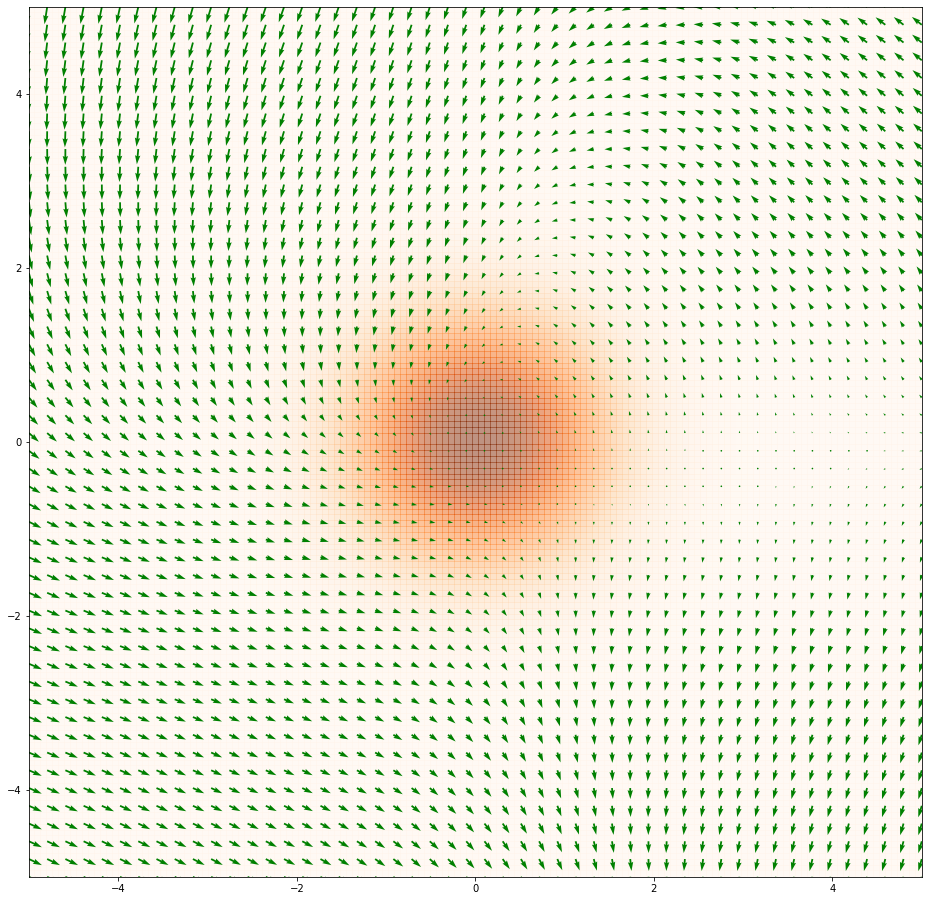

In [95]:
plt.figure(figsize=[16, 16])
plot.plot_fun_2d(dis.pdf, alpha=0.5)
plot_gradient_field(v)

# New Optax GradientTransformation

In [3]:
from typing import Any, Callable, NamedTuple, Optional, Sequence, Tuple, Union
OptState = NamedTuple  # Transformation states are (possibly empty) namedtuples.
Params = Any  # Parameters are arbitrary nests of `jnp.ndarrays`.
Updates = Params  # Gradient updates are of the same type as parameters.

In [31]:
class NoState(OptState):
    """Use for stateless gradient transformations"""

def sqrt():
    """
    Optax GradientTransformation that takes sqrt of gradients

    Returns:
        An (init_fn, update_fn) tuple.
    """
    def init_fn(_):
        return NoState

    def update_fn(updates, state, params=None):
        del params
        updates = jax.tree_map(np.sqrt, updates)
        return updates, state
    return optax.GradientTransformation(init_fn, update_fn)

In [92]:
def loss_fn(param):
    return (param + 3)**2

lr = 1e-1
params = 4.
# opt = optax.sgd(learning_rate=lr)
opt = optax.chain(
    sqrt(),
    optax.sgd(learning_rate=lr))

state = opt.init(params)
losses = []
param_log = []
grads = []
update_grads = []

In [97]:
g, state = opt.update(1., state)
g

DeviceArray(-0.1, dtype=float32)

In [94]:
for _ in range(1):
    loss, g = value_and_grad(loss_fn)(params)
    param_log.append(params)
    losses.append(loss)
    grads.append(g)

    g, state = opt.update(g, state)
    update_grads.append(g)
    params = optax.apply_updates(params, g)

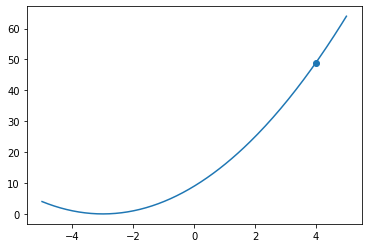

In [87]:
plot.plot_fun(loss_fn)
plt.scatter(param_log, losses)

In [91]:
i=0
print("pure grad:", grads[i])
print("update:", update_grads[i])
print("sqrt(lr*pure_grad):", np.sqrt(grads[i]*lr))
print("-lr*sqrt(pure_grad):", -np.sqrt(grads[i])*lr)

pure grad: 14.0
update: -0.37416574
sqrt(lr*pure_grad): 1.183216
-lr*sqrt(pure_grad): -0.37416574


# Optax

In [242]:
def net_fn(batch):
    net = hk.nets.MLP([32, 32, 1], w_init=hk.initializers.VarianceScaling(2.0))
    return net(3*batch)
net = hk.transform(net_fn)

@jit
def loss_fn(params, batch):
    return np.mean((net.apply(params, None, batch) - np.sin(10*batch))**2)

In [246]:
# init net and optimizer
dummy_batch = onp.random.rand(10, 1)
params = net.init(key, dummy_batch)

opt = optax.sgd(1e-2)
state = opt.init(params)

losses=[]

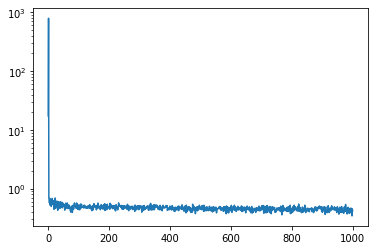

In [247]:
for i in range(10**3):
    key, subkey = random.split(key)
    batch = random.uniform(subkey, shape=(100, 1), minval=-2, maxval=2)
    step_loss, grads = value_and_grad(loss_fn)(params, batch)
    grads, state = opt.update(grads, state, params)
    params = optax.apply_updates(params, grads)
    losses.append(step_loss)
plt.plot(losses)
plt.yscale("log")

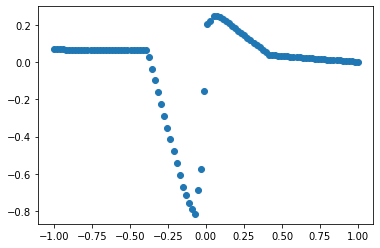

In [248]:
x = np.linspace(-1, 1, 100).reshape(100, 1)
plt.scatter(x, net.apply(params, None, x))

# Init neural nets

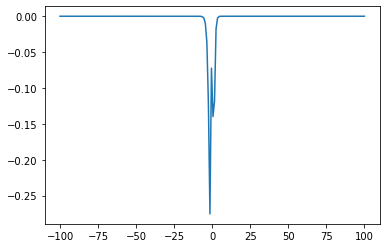

In [90]:
key, subkey = random.split(key)
net = nets.build_mlp([32, 32, 1], activate_final=True)
x_dummy = np.array([0.])
init_params = net.init(subkey, x_dummy)

@utils.reshape_input
def f(x):
    return net.apply(init_params, None, x)

xlims = (-100, 100)
plot.plot_fun(f, lims=xlims)

# non diff stuff

In [5]:
@jax.custom_transforms
def safe_sqrt(x):
    return np.sqrt(x)
jax.defjvp(safe_sqrt, lambda g, ans, x: 0.5 * g / np.where(x > 0, ans, np.inf) )

In [2]:
grad(lambda x: np.sqrt(x)**2)(0.)

DeviceArray(nan, dtype=float32)

In [6]:
grad(lambda x: safe_sqrt(x)**2)(0.) # baad

DeviceArray(0., dtype=float32)

# confirm relationship between L2 norm and RKHS norm

In [5]:
kernel = kernels.get_rbf_kernel(1)
q = distributions.Gaussian(0, 1)
s = q.sample(10_000)

@partial(jit, static_argnums=0)
def l2_and_rkhs_norm(kernel, x):
    """Return both norms of k(x, _)"""
    x = np.squeeze(np.array(x))
    def kx(y):
        return kernel(x, np.squeeze(y))
    l2_norm = utils.l2_norm(s, kx)
    rkhs_norm = kernel(x, x)
    return l2_norm, rkhs_norm

In [6]:
xgrid = np.linspace(-3, 3, num=50)
norms = vmap(l2_and_rkhs_norm, (None, 0))(kernel, xgrid)
norms = np.array(norms)

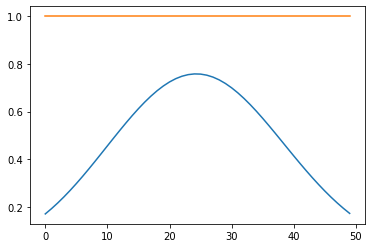

In [7]:
plt.plot(norms.T)

In [31]:
l2_and_rkhs_norm(kernel, 2.)

(DeviceArray(0.7579048, dtype=float32), DeviceArray(1., dtype=float32))

# benchmark container

In [ ]:
class Benchmarks():
    def __init__(target, proposal, lambda_reg):
        pass

# compute globally maximal stein discrepancy in $L_2$

In [3]:
def get_optimal_sd(key, lambda_reg, target, proposal, batch_size=400):
    """Compute mean and stddev of optimal SD under proposal."""
    def optimal_grad(x):
        div = 2*lambda_reg
        return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / div

    @partial(jit, static_argnums=1)
    def compute_sd(samples, fun):
        return stein.stein_discrepancy(samples, target.logpdf, fun)

    def get_sds(key, n_samples, fun):
        sds = []
        for subkey in random.split(key, 100):
            samples = proposal.sample(n_samples, key=subkey)
            sds.append(compute_sd(samples, fun))
        return sds

    sds_optimal = get_sds(key, batch_size, optimal_grad)
    return np.mean(sds_optimal), np.std(sds_optimal)

# numpy tricks

In [14]:
rain_drops = onp.zeros(5, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

rain_drops['position']

<ipython-input-14-466632b10b87>:1: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  rain_drops = onp.zeros(5, dtype=[('position', float, 2),


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

# new distributions

In [ ]:

target = distributions.GaussianMixture()
circle_mix = distributions.Setup

# Particle class

In [3]:
from models import Particles

In [7]:
setup = distributions.Setup(target=distributions.Gaussian(0, 16), proposal=distributions.Gaussian(0, 1))
# setup = distributions.double_mixture
# setup = distributions.banana_target
target, proposal = setup.get()
kernel = kernels.get_rbf_kernel(1)

def score_est_unnormalized(x, inducing_particles):
    """kernel-smoothed estimate of grad(log q(x))"""
    return -np.mean(vmap(grad(kernel), (0, None))(inducing_particles, x))

def phistar_unnormalized(x, inducing_particles, aux=False):
    out = stein.phistar_i(x, inducing_particles, target.logpdf, kernel, aux=aux)
    if aux:
        neg_dKL, auxdata = out
        out = (-neg_dKL, auxdata)
    else:
        out = -out
    return out

## Normalize score estimate
s = proposal.sample(10_000)
inducing_particles = proposal.sample(10_000)
l2_score     = utils.l2_norm(s, grad(proposal.logpdf))
l2_score_est = utils.l2_norm(s, lambda x: score_est_unnormalized(x, inducing_particles))

def score_est(x, inducing_particles):
    """kernel-smoothed estimate of grad(log q(x)). Normalized."""
    return score_est_unnormalized(x, inducing_particles) * l2_score/l2_score_est

## Normalize kernel
def grad_kl(x):
    """True grad(KL)"""
    return setup.grad_kl(x)

l2_grad_kl = utils.l2_norm(np.squeeze(s), grad_kl)
l2_phistar = utils.l2_norm(s, lambda x: phistar_unnormalized(x, inducing_particles))

def phistar(x, inducing_particles, aux):
    if aux:
        out = phistar_unnormalized(x, inducing_particles, aux)
        return [o * l2_grad_kl/l2_phistar for o in out]
    else:
        return phistar_unnormalized(x, inducing_particles, aux) * l2_grad_kl/l2_phistar

In [8]:
def dKL(x, inducing_particles):
    """Estimate of grad(KL(x))"""
    dKL = score_est(x, inducing_particles) - grad(target.logpdf)(x)
    return dKL


def dKL_batched(particles, inducing_particles, aux=False):
    out = vmap(dKL, (0, None))(particles, inducing_particles)
    return (out, _) if aux else out


def phistar_batched(particles, inducing_particles, aux=False):
    return vmap(phistar, (0, None, None))(particles, inducing_particles, aux)

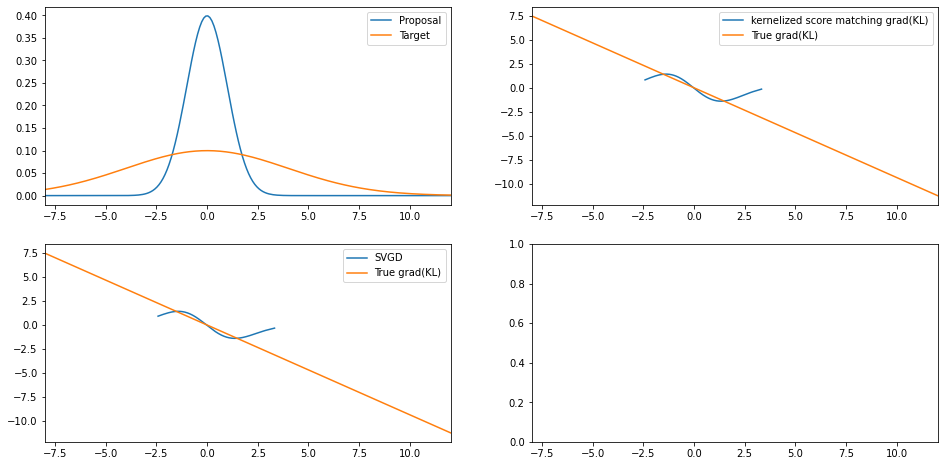

In [9]:
inducing_particles = proposal.sample(1000)
x = proposal.sample(1000)

xgrid = x.sort(axis=0)

fig, axs = plt.subplots(2,2, figsize=[16, 8])
axsiter = iter(axs.flatten())
xlims = (-8, 12)

ax = next(axsiter)
setup.plot(ax=ax, lims=xlims)
ax.legend()

ax = next(axsiter)
ax.plot(xgrid, dKL_batched(xgrid, inducing_particles), label="kernelized score matching grad(KL)")
plot.plot_fun(grad_kl, lims=xlims, ax=ax, label="True grad(KL)")
ax.legend()

ax = next(axsiter)
ax.plot(xgrid, phistar_batched(xgrid, inducing_particles), label="SVGD")
plot.plot_fun(grad_kl, lims=xlims, ax=ax, label="True grad(KL)")
ax.legend()

ax = next(axsiter)

for ax in axs.flatten():
    ax.set_xlim(xlims)

In [10]:
particles_svgd = Particles(key,
                           phistar_batched,
                           proposal,
                           learning_rate=0.01)

particles_score = Particles(key,
                            dKL_batched,
                            proposal,
                            learning_rate=0.01)

In [11]:
for _ in range(2500):
    inducing_particles = particles_svgd.get_params()
    particles_svgd.step(params=inducing_particles)

# _ = plt.hist(particles_svgd.get_params()[:,0], bins=25, density=True, alpha=0.5)
# _ = plot.plot_fun(target.pdf, lims=(-10, 10))

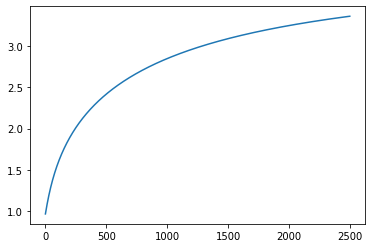

In [12]:
plt.plot(particles_svgd.rundata["std"], label="SVGD")

In [ ]:
sdfkj

# markdown image link converter

Format 1:
```
![img](/home/lauro/obsidian/Pasted image 14.png)
```
Format 2:
```
![[Pasted image 5.png]]
```

In [ ]:
string_f1 = "kxkjdf![img](/home/lauro/obsidian/Pasted image 14.png)xdkfjdlk\n"
string_f2 = "![[Pasted image 14.png]]sdlfsdfsdfj\n"

In [ ]:
def f1_to_f2(string):
    ind_begin = string.rindex("/") # last occurence of /
    ind_end = string.rindex(")") # last occurence of )
    name = string[ind_begin+1:ind_end]
    return f"![[{name}]]"

def f2_to_f1(string):
    ind_begin = string.index("!")
    ind_end = string.rindex("]")
    name = string[ind_begin+3:ind_end-1]
    return f"![img](/home/lauro/obsidian/{name})"

def line_is_f1_img(line):
    return line.startswith("![img]") and line.endswith(".png)\n")

def line_is_f2_img(line):
    return line.startswith("![[") and line.endswith(".png]]\n")

In [ ]:
def convert_file(filename, direction="f1_to_f2"):
    if direction == "f1_to_f2":
        convert = f1_to_f2
        is_img = line_is_f1_img
    elif direction == "f2_to_f1":
        convert = f2_to_f1
        is_img = line_is_f2_img
    else:
        raise ValueError()
    with open(filename, "r") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if is_img(line):
                line_converted = convert(line)
                lines[i] = line_converted + "\n"
                print(f"changed line: {line}")
    with open(filename, "w") as f:
        f.writelines(lines)

In [ ]:
# filename = "/home/lauro/testfile"
# convert_file(filename, direction="f1_to_f2")

In [ ]:
# filename = "/home/lauro/obsidian/Master thesis/Updates/Update September 8.md"

In [ ]:
convert_file(filename, direction="f1_to_f2")